In [11]:
# Celda 1: Configuración del entorno
import sys
import os
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import joblib

# Ajuste de rutas:
# Si tu notebook está en la carpeta 'notebooks/', necesitamos subir un nivel
# para ver la carpeta 'src/'.
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

# Importamos tus módulos personalizados del TFG
from src.load_data import load_fraud_csv, load_credit_scoring_data
from src.train_model import train_model_with_cost
import src.explicabilidad as xai_tools

# Inicializamos JS para ver los gráficos interactivos de SHAP
shap.initjs()

print("Entorno configurado correctamente.")

Entorno configurado correctamente.


In [2]:
# Celda 2: Carga de datos
ruta_dataset = '../data/credit_card.csv'

if not os.path.exists(ruta_dataset):
    print(f"⚠️ Error: No se encuentra el archivo en {ruta_dataset}")
else:
    # Usamos tu función de src/load_data.py
    df, X, y = load_fraud_csv(ruta_dataset)
    print("Datos cargados.")

Loaded 284,807 transactions from credit_card.csv
Fraud rate: 0.17275%
Total fraud amount: $60,127.97
Datos cargados.


In [3]:
# Celda 3: Split de datos y preparación
# Dividimos en 80% train / 20% test, manteniendo la proporción de fraude (stratify)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Extraemos la variable 'Amount' del train para el entrenamiento con coste sensible
amount_train = X_train['Amount']

print(f"Dimensiones de X_test: {X_test.shape}")

Dimensiones de X_test: (56962, 29)


In [4]:
# Celda 4: Entrenamiento del Modelo Ganador (XGBoost Factor 20)
print("Entrenando XGBoost con Coste (Factor=20)...")

# Llamamos a tu función de src/train_model.py
model = train_model_with_cost(X_train, y_train, amount_train, model_type="xgb", amount_factor=20)

print("¡Modelo entrenado y listo para explicar!")

Entrenando XGBoost con Coste (Factor=20)...
Model XGB trained (factor=20)
¡Modelo entrenado y listo para explicar!


In [5]:
# Celda 5: Cálculo de valores SHAP con Muestreo (Sampling)
print("Calculando valores SHAP... (esto puede tardar unos segundos)")

# TRUCO: Usamos una muestra de 1000 transacciones para evitar que se cuelgue.
# 1000 es suficiente para una explicabilidad global fiable.
X_test_sample = X_test.sample(50000, random_state=42)

# Inicializamos el explicador para árboles (optimizado para XGBoost)
explainer = shap.TreeExplainer(model)

# Calculamos los valores SHAP solo para la muestra
shap_values = explainer(X_test_sample)

print(f"Cálculo completado. Forma de los valores SHAP: {shap_values.shape}")

Calculando valores SHAP... (esto puede tardar unos segundos)
Cálculo completado. Forma de los valores SHAP: (50000, 29)


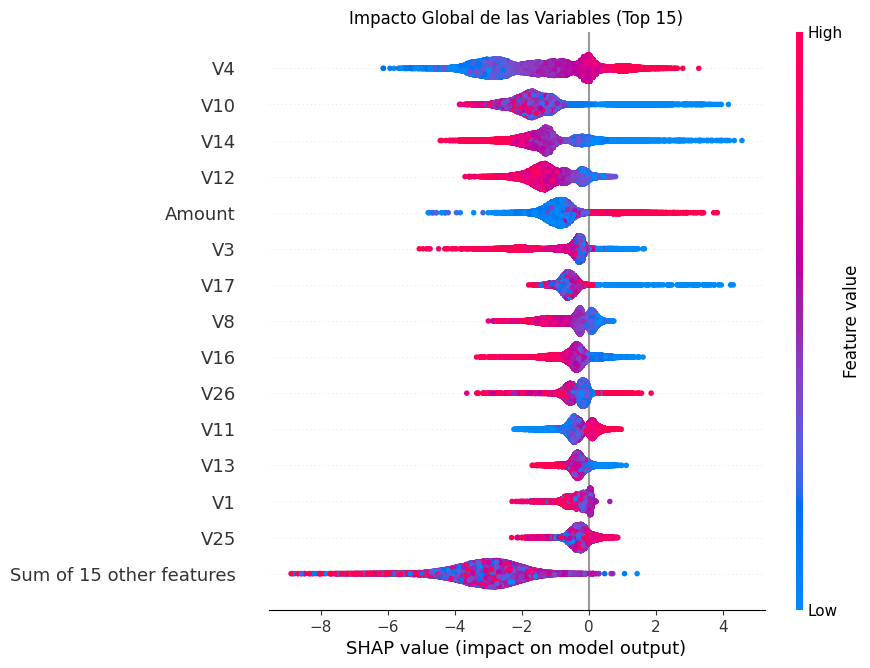

In [6]:
# Celda 6: Gráfico Global (Beeswarm)
plt.figure()
plt.title("Impacto Global de las Variables (Top 15)")

# El gráfico Beeswarm muestra la importancia y el sentido (positivo/negativo)
shap.plots.beeswarm(shap_values, max_display=15)

In [7]:
# Celda 7: Buscar un fraude real dentro de la muestra
# Filtramos los índices que son fraude (y=1) y que además están en nuestra muestra pequeña
indices_fraude_real = y_test[y_test == 1].index
indices_en_muestra = [i for i in indices_fraude_real if i in X_test_sample.index]
print(len(indices_en_muestra))

if len(indices_en_muestra) > 0:
    id_transaccion = indices_en_muestra[0] # Cogemos el primero que encontremos
    
    # Buscamos en qué posición (0 a 999) de la matriz SHAP está este ID
    posicion_shap = list(X_test_sample.index).index(id_transaccion)
    
    print(f"Vamos a analizar la transacción ID: {id_transaccion}")
    print(f"Monto de la transacción: {X_test.loc[id_transaccion, 'Amount']}€")
    print(f"Posición en el array SHAP: {posicion_shap}")
else:
    print("No se encontraron fraudes reales en la muestra aleatoria de 1000.")
    # Si pasa esto, aumenta el tamaño de la muestra en la Celda 5 a 2000 o 3000.

82
Vamos a analizar la transacción ID: 77348
Monto de la transacción: 0.01€
Posición en el array SHAP: 45341


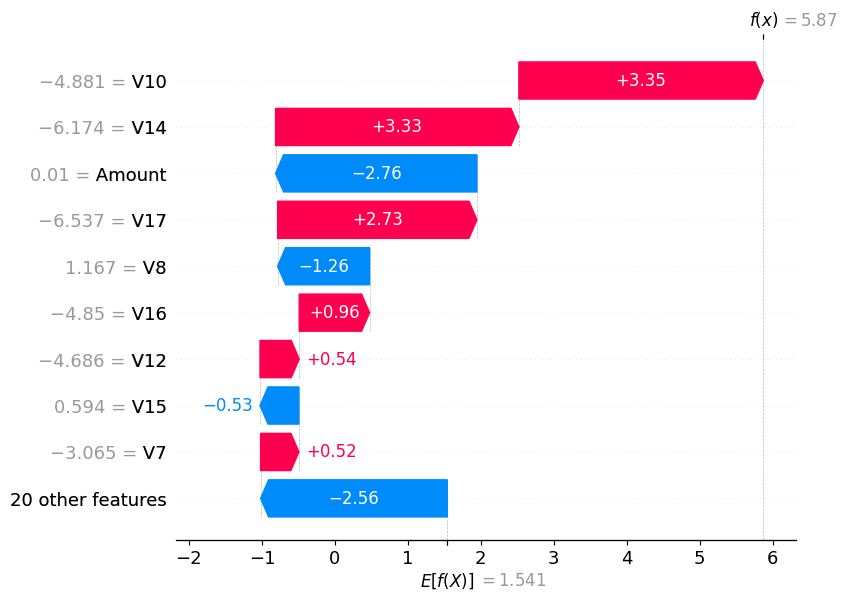

In [8]:
# Celda 8: Gráfico de Cascada (Waterfall) para el fraude seleccionado
if len(indices_en_muestra) > 0:
    plt.figure()
    # Pasamos el objeto shap_values específico de esa fila
    shap.plots.waterfall(shap_values[posicion_shap])


--- Buscando Falsos Negativos (Fraudes que se nos escaparon) ---
Analizando Falso Negativo ID: 157585
Importe perdido: 1.0€


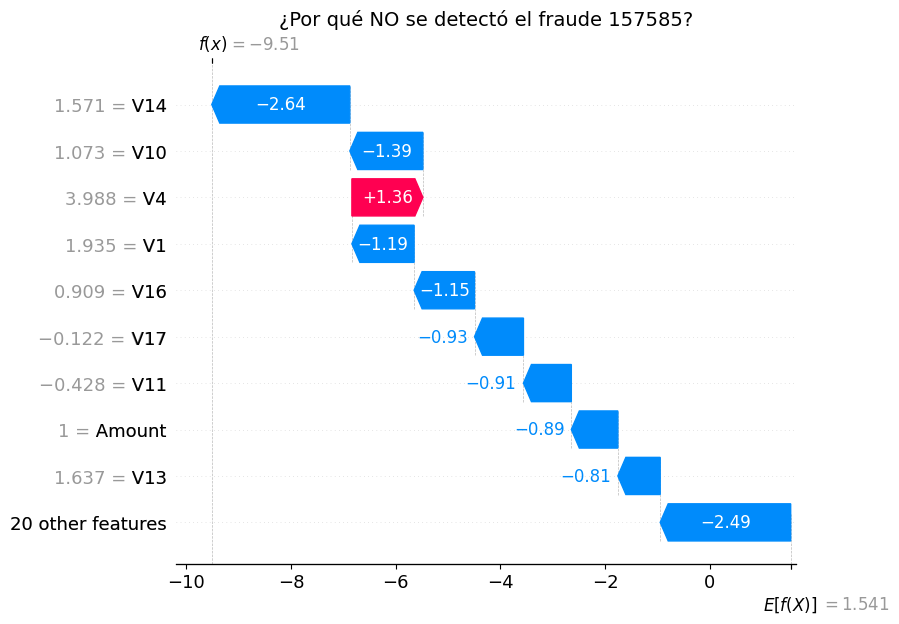

In [9]:
# Celda 10: Análisis de Errores - Explicar un Falso Negativo (Fraude no detectado)
print("\n--- Buscando Falsos Negativos (Fraudes que se nos escaparon) ---")

# 1. Hacemos predicciones sobre la muestra
preds_muestra = model.predict(X_test_sample)

# 2. Buscamos índices donde Realidad=1 (Fraude) pero Predicción=0 (Legítimo)
falsos_negativos = [i for i, y_real, y_pred in zip(X_test_sample.index, y_test.loc[X_test_sample.index], preds_muestra) 
                    if y_real == 1 and y_pred == 0]

if len(falsos_negativos) > 0:
    idx_fn = falsos_negativos[0] # Cogemos el primero
    pos_fn = list(X_test_sample.index).index(idx_fn)
    
    print(f"Analizando Falso Negativo ID: {idx_fn}")
    print(f"Importe perdido: {X_test_sample.loc[idx_fn, 'Amount']}€")
    
    # Waterfall plot para ver por qué el modelo bajó la puntuación
    plt.figure()
    shap.plots.waterfall(shap_values[pos_fn], show=False)
    plt.title(f"¿Por qué NO se detectó el fraude {idx_fn}?", fontsize=14)
    plt.show()
else:
    print("¡Increíble! El modelo no tuvo falsos negativos en esta muestra (o la muestra es muy pequeña).")

# ==========================================
# PARTE 2: EXPLICABILIDAD - CREDIT SCORING (SHAP)
# ==========================================

En esta sección utilizamos la técnica **SHAP (SHapley Additive exPlanations)** para abrir la "caja negra" de nuestro modelo de riesgo de crédito.
El objetivo es responder a dos preguntas clave para el negocio y el regulador:
1.  **Explicabilidad Global:** ¿Qué variables (Ingresos, Deuda, Edad...) tienen más peso general en la decisión de conceder un crédito?
2.  **Explicabilidad Local:** Ante un cliente concreto rechazado, ¿cuáles fueron las razones exactas? (Esencial para dar feedback al cliente).

In [12]:
# 1. Cargar Modelo Ganador
model_path = '../models/credit_scoring_best_model.pkl'
try:
    model_cs = joblib.load(model_path)
    print(f"✅ Modelo cargado: {model_path}")
except FileNotFoundError:
    print(f"❌ Error: No se encontró el modelo en {model_path}. Ejecuta el análisis financiero primero.")

# 2. Cargar Datos (Necesitamos el X_test para explicar)
# Cargamos y dividimos igual que en el entrenamiento para ser consistentes
df_cs, X_cs, y_cs = load_credit_scoring_data('../data/cs-training.csv')
_, X_test_cs, _, _ = train_test_split(
    X_cs, y_cs, test_size=0.2, stratify=y_cs, random_state=42
)

print(f"   Datos de test listos: {X_test_cs.shape[0]} clientes.")

✅ Modelo cargado: ../models/credit_scoring_best_model.pkl
Credit Scoring Data Loaded: 150,000 records
Default Rate: 6.68%
Total Estimated Exposure: $4,816,130,055
   Datos de test listos: 30000 clientes.


In [15]:
# 3. Preparar el Explainer y Calcular SHAP Values
# Usamos una muestra aleatoria para agilizar el cálculo, ya que SHAP es costoso computacionalmente.
SAMPLE_SIZE = 20000
X_test_sample = X_test_cs.sample(min(SAMPLE_SIZE, len(X_test_cs)), random_state=42)

print(f"Calculando valores SHAP sobre una muestra de {len(X_test_sample)} clientes (esto puede tardar un poco)...")

# TreeExplainer funciona para XGBoost, LightGBM y Random Forest
explainer_cs = shap.TreeExplainer(model_cs)
shap_values_cs = explainer_cs(X_test_sample)

# Ajuste para modelos que devuelven una lista (como Random Forest Clasificador)
# Nos quedamos con la clase 1 (Probabilidad de Default)
if isinstance(shap_values_cs, list):
    shap_values_cs = shap_values_cs[1]
elif len(shap_values_cs.shape) == 3:
    shap_values_cs = shap_values_cs[:, :, 1]

print("✅ Valores SHAP calculados correctamente.")

Calculando valores SHAP sobre una muestra de 20000 clientes (esto puede tardar un poco)...
✅ Valores SHAP calculados correctamente.


### 2.1 Interpretación Global: Impacto de las Variables

El gráfico de abejas (**Beeswarm**) resume toda la información del modelo:
* **Eje Y:** Las variables más importantes ordenadas de arriba a abajo.
* **Eje X (SHAP Value):** Impacto en la predicción. Valores positivos (derecha) aumentan la probabilidad de impago. Valores negativos (izquierda) la reducen.
* **Color:** Valor de la variable (Rojo = Alto, Azul = Bajo).

*Ejemplo de lectura:* Si `RevolvingUtilizationOfUnsecuredLines` muestra puntos rojos a la derecha, significa que **un alto uso de las líneas de crédito aumenta el riesgo de impago**.

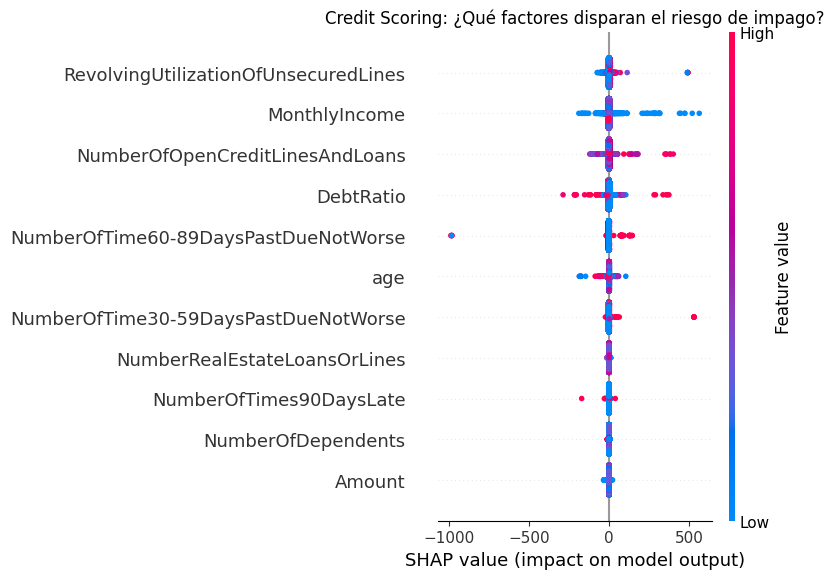

In [16]:
plt.figure(figsize=(10, 6))
plt.title("Credit Scoring: ¿Qué factores disparan el riesgo de impago?")
# max_display limita el gráfico a las variables más relevantes
shap.plots.beeswarm(shap_values_cs, max_display=12, show=False)

# Guardar y mostrar
if not os.path.exists('../results'):
    os.makedirs('../results')
plt.tight_layout()
plt.savefig('../results/shap_beeswarm_credit.png')
plt.show()

### 2.2 Interpretación Local: Análisis de un Caso de Alto Riesgo

A continuación, seleccionamos un cliente específico de nuestra muestra que el modelo ha clasificado como de **Muy Alto Riesgo**.
Utilizamos un gráfico de cascada (**Waterfall**) para desglosar su puntuación:
* Cada barra muestra cómo una variable específica empujó la probabilidad de impago hacia arriba (Rojo) o hacia abajo (Azul), partiendo de la tasa base promedio.

--- ANÁLISIS DE CASO INDIVIDUAL ---
Cliente Índice: 50
Probabilidad de Impago Predicha: 100.00% (Muy Alta)
Desglose de la decisión:


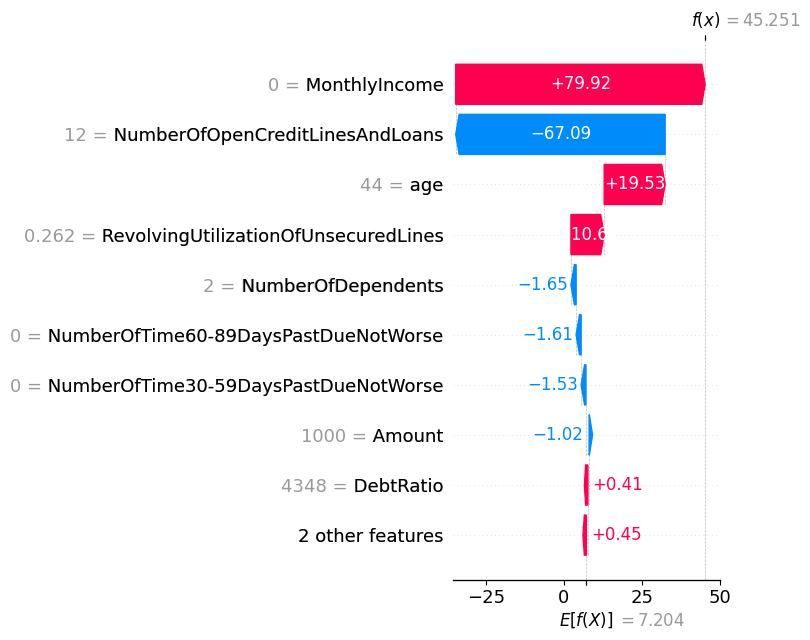

In [17]:
# 1. Identificar al cliente más riesgoso de la muestra
probs_sample = model_cs.predict_proba(X_test_sample)[:, 1]
high_risk_idx = np.argmax(probs_sample) # Índice del cliente con mayor prob. de default

# 2. Extraer sus datos para SHAP
# shap_values_cs es un objeto complejo, accedemos al elemento por índice
client_shap = shap_values_cs[high_risk_idx]
client_prob = probs_sample[high_risk_idx]

print(f"--- ANÁLISIS DE CASO INDIVIDUAL ---")
print(f"Cliente Índice: {high_risk_idx}")
print(f"Probabilidad de Impago Predicha: {client_prob:.2%} (Muy Alta)")
print("Desglose de la decisión:")

# 3. Gráfico Waterfall
plt.figure()
shap.plots.waterfall(client_shap, max_display=10, show=False)
plt.tight_layout()
plt.savefig('../results/shap_waterfall_credit_highrisk.png')
plt.show()